#Imports & Installs

In [ ]:
#installs
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
!pip install google-play-scraper
!pip install sentiment-analysis-spanish
!pip install xgboost
#imports
from pandas_profiling import ProfileReport as pr
import matplotlib.pyplot as plt
import datetime
from google_play_scraper import app, Sort, reviews_all
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud 
from nltk import FreqDist
from sentiment_analysis_spanish import sentiment_analysis
from sklearn.model_selection import KFold, cross_val_score, StratifiedShuffleSplit
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation

#**ROBINFOODS**

En la industria de los alimentos, Robinfoods ha alcanzado la fama por ser la cadena más larga de cloud restaurant de Latin America y apunta a hacer los pioneros en eliminar 100% el contacto humano en la cadena de servicio de acuerdo con Semana. En este corto repositorio, se analizarán las actitudes de las personas frente a la app, y cómo esto podría ser clave para el crecimiento de la app.

Puntualmente, buscaremos:

- Analizar, entender cómo mejorar la experiencia de los usuarios.
- Proyectar la calificación de la app.
- Extraer insights de negocio.

##**Vista de helicóptero**
Este repositorio se llevará acabo de la siguiente manera:

1.) Recolleción de la data

2.) Data wrangling

3.) Exploratory analysis

4.) Sentiment analysis

5.)  Topic modeling

##**Recolección de la data**

Para este proceso, buscaremos la data por medio de web scrapping en la tienda de Google Play, pues el 86.6% de los Colombianos usan Android según un estudio de ComScore. Para este proceso usaremos la biblioteca Google Play Scraper ya que en algunas ocasiones, acceder con Selenium o Beautiful Soup podría ser prohibido.

In [ ]:
#Ahora importamos lo necesario para el proceso
link = 'https://play.google.com/store/apps/details?id=com.muy.app'
link_id = link.split("id=")[1]

In [ ]:
#Ahora descargamos todos los reviews de RobinFood
reviews = reviews_all(
    link_id,
    sleep_milliseconds=0, # defaults to 0
    lang='es', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [ ]:
#Como hemos creado un output en formato json, debemos convertirlo a Pandas DF
dataset = pd.DataFrame(np.array(reviews),columns = ['Reviews'])
dataset = dataset.join(pd.DataFrame(dataset.pop('Reviews').tolist()))
dataset.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOH_90AeMuTrDXZs-6QOuNezHPaExgADgFlzkur...,"Henao Gonzalez, Victor Hugo",https://play-lh.googleusercontent.com/a/AATXAJ...,Malisima. Esperé la orden y me notificó que el...,1,0,2.0.46,2021-08-19 01:35:19,None,NaT
1,gp:AOqpTOFS8ZZa8MqI8IdvazA3INUcvS57TmXW_DRgemL...,Gabriel Saavedra,https://play-lh.googleusercontent.com/a-/AOh14...,"Atraes lo que irradias, uno piensa tranquilo y...",5,0,2.0.46,2021-08-18 18:22:25,None,NaT
2,gp:AOqpTOEFO_1vrhnk0-9-gtICGnvOG8gAG-O-GD_iGs3...,м є l ι ѕ ѕ α.,https://play-lh.googleusercontent.com/a-/AOh14...,Terrible jaja. Decidí darle una oportunidad a ...,1,0,2.0.46,2021-08-17 23:05:28,None,NaT
3,gp:AOqpTOH-nG7L1UqnUBzBv3iNw1RRaFlno1W91HzFdBP...,Harrison marin,https://play-lh.googleusercontent.com/a-/AOh14...,Muy mala apliccacion no tienes ercicio técnico...,1,0,2.0.46,2021-08-17 21:41:25,None,NaT
4,gp:AOqpTOHmP0wPY1vuGI3Ep0ZDZPAmbs8iXDU2aXQVYjr...,Juan Jose Rivera Zapata,https://play-lh.googleusercontent.com/a-/AOh14...,"Exageramente mala, la descargue e hice un pedi...",1,0,None,2021-08-17 00:58:17,None,NaT


##**Data wrangling**##
Una vez con la data de forma estructurada, procederemos a analizar aquellos espacios vacíos, columnas obsoletas y formato de los datos. Por un lado, se encontraron vacios en tres columnas. Sin embargo, dos de ellas corresponden a replays de los comentarios. Esto es natural pues no todos los comentarios deben estar obligatoriamente con un thread. Por esto se llenarán estos datos con la palabra Missing. En cuanto a ReviewCreatedversion, se encontró que aquella versión le pertenecía un periodo de tiempo en específico, por lo que se llenaron en orden de recencia.

In [ ]:
#en primer lugar crearemos una copia
df = dataset.copy()
#Ahora se buscaran NaNs
for column in df.columns:
    if df[column].isna().sum() != 0:
        print("{} empty values at {}".format(df[column].isna().sum(), column))

73 empty values at reviewCreatedVersion
646 empty values at replyContent
646 empty values at repliedAt


In [ ]:
#Fijaremos la atencion en la columna ReviewCreatedversion
print(df.reviewCreatedVersion.unique())
#Se buscara una relacion con la fecha y la version
df['date'] = pd.to_datetime(df['at'], format = '%Y-%m-%d %H:%M:%S')
versions = df.groupby(['reviewCreatedVersion'], as_index = False).agg({'date':'max',
                                                                      'date':'nunique'})
#ahora como se sabe que cada version tiene una fecha consigo, se usara para llenar vacios
df.sort_values(by = 'date', inplace= True)
df.reviewCreatedVersion.fillna(method = 'ffill', inplace = True)
#por ultimo llenemos los espacios vacios de replays con no aplica
df.replyContent.fillna('Missing', inplace =True)
df.repliedAt.fillna('Missing', inplace =True)
df.info()

['1.0.8' '1.1.7' '1.1.11' '1.1.12' '1.0.7' '1.2.0' '1.2.1' '1.2.2' '1.2.3'
 '1.2.4' '1.2.5' '1.2.6' '1.2.7' '1.2.8' '1.2.9' '1.2.10' '1.2.11'
 '1.2.12' '1.3.1' '1.3.3' '1.3.4' '1.3.6' '1.4.0' '1.5.1' '1.5.2' '1.5.4'
 '1.5.5' '1.5.6' '1.5.3' '1.5.7' '1.5.8' '1.5.9' '1.5.10' '1.5.12'
 '1.5.13' '1.5.15' '1.5.16' '1.5.17' '1.5.19' '1.5.20' '1.5.21' '1.5.22'
 '1.5.23' '1.6.0' '1.6.5' '1.6.6' '1.6.9' '1.6.10' '1.6.11' '1.6.12'
 '1.6.13' '1.6.14' '1.7.0' '1.7.3' '1.7.4' '1.7.6' '1.7.7' '1.7.8' '1.7.9'
 '1.7.10' '1.7.12' '1.7.14' '1.7.15' '1.7.16' '1.7.18' '1.7.19' '1.7.20'
 '1.7.21' '1.7.23' '1.7.24' '1.7.25' '1.7.26' '1.7.27' '1.7.28' '1.7.29'
 '2.0.0' '2.0.4' '2.0.6' '2.0.7' '2.0.8' '2.0.9' '2.0.10' '2.0.11'
 '2.0.13' '2.0.14' '2.0.15' '2.0.16' '2.0.17' '2.0.19' '2.0.22' '2.0.23'
 '2.0.24' '2.0.26' '2.0.27' '2.0.28' '2.0.29' '2.0.30' '2.0.32' '2.0.33'
 '2.0.36' '2.0.37' '2.0.38' '2.0.40' '2.0.39' '2.0.41' '2.0.42' '2.0.43'
 '2.0.44' '2.0.45' '2.0.46']
<class 'pandas.core.frame.DataFrame'>
I

#**Exploratory analysis**##

Tomamos los datos y construimos un reporte de perfilamiento exploratorio. Allí, se pudieron observar algunas correlaciones, datos estadísticos sobre los puntajes y de manera muy general, la distribución del rating per se.

Posteriormente, se realizó una gráfica para comparar la evolución del rating contra el tiempo. Se observó que aunque la aplicación empezó con buenos puntajes, existe una tendencia hacia la baja del puntaje.

Por último, se analizó el tiempo de respuesta a los comentarios de los usuarios. Se observó que en promedio, RobinFoods tarda 7 días aproximadamente en responder. Sin embargo, se encuentran picos de más 99 días, lo cual indica que no existe constancia en este sentido.



In [ ]:
report = pr(df, explorative = True, sensitive = True,
            dark_mode = True)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Rating a lo largo del tiempo')

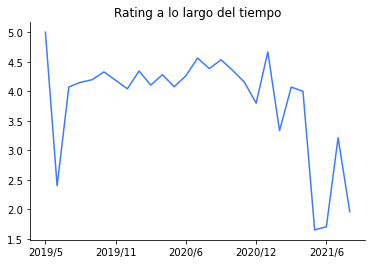

In [ ]:
#ahora veamos la evolucion de los ratings sobre el tiempo
ax =  plt.gca()
last_months = df.copy()
#extraemos ano y mes para ignorar los dias
last_months['year'] = pd.DatetimeIndex(last_months['date']).year
last_months['month'] = pd.DatetimeIndex(last_months['date']).month
#agrupamos sacando el promedio
last_months = last_months.groupby(['year', 'month'], as_index=False)['score'].mean()
last_months['date'] = last_months['year'].astype(str) + "/"+ last_months['month'].astype(str) 
#Visualizamos el comportamiento
plt.plot(last_months.date, last_months.score, c = 'xkcd:lightish blue')
ax.set_xticks(ax.get_xticks()[::6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Rating a lo largo del tiempo')

In [ ]:
#Por ultimo miremos la inmediatez de respuesta
df['reply'] = pd.to_datetime(df['repliedAt'], format = '%Y-%m-%d %H:%M:%S',errors='coerce')
df['response_time'] = df.reply - df.date
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 1015 to 0
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   reviewId              1016 non-null   object         
 1   userName              1016 non-null   object         
 2   userImage             1016 non-null   object         
 3   content               1016 non-null   object         
 4   score                 1016 non-null   int64          
 5   thumbsUpCount         1016 non-null   int64          
 6   reviewCreatedVersion  1016 non-null   object         
 7   at                    1016 non-null   datetime64[ns] 
 8   replyContent          1016 non-null   object         
 9   repliedAt             1016 non-null   object         
 10  date                  1016 non-null   datetime64[ns] 
 11  reply                 370 non-null    datetime64[ns] 
 12  response_time         370 non-null    timedelta64[ns]
dtypes: 

average reply time:
7 days 15:42:02.908108108


Text(0.5, 1.0, 'Tiempo promedio de respuesta en el tiempo')

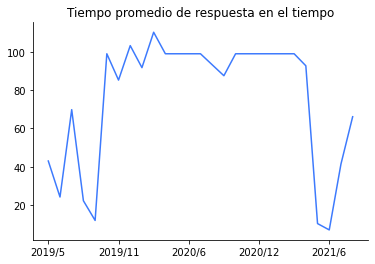

In [ ]:
ax =  plt.gca()
print('average reply time:')
print(np.mean(df.response_time))
last_months = df.copy()
last_months.response_time.fillna(pd.Timedelta('99 days'), inplace =True)
#extraemos ano y mes para ignorar los dias
last_months['year'] = pd.DatetimeIndex(last_months['date']).year
last_months['month'] = pd.DatetimeIndex(last_months['date']).month
last_months['days'] = last_months['response_time'].datetime.days.astype(int)
#agrupamos sacando el promedio
last_months = last_months.groupby(['year', 'month'], as_index=False)['days'].mean()
last_months['date'] = last_months['year'].astype(str) + "/"+ last_months['month'].astype(str)
#last_months.replace({999:np.nan}, inplace= True)
plt.plot(last_months.date, last_months.days, c = 'xkcd:lightish blue')
ax.set_xticks(ax.get_xticks()[::6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Tiempo promedio de respuesta en el tiempo')


#**Sentiment analysis**#

Para hacer sentimiento de análisis, se usaron distintos métodos para examinarlo. Por tanto, te invito a seguir este hilo que abriremos acá. En primera medida, se buscaron stopwords en Español, esto es sumamente importante pues en otro idioma serían obsoletos.

Adicionalmente se crean dos funciones, una para realizar stemming (el proceso de extraer la raíz de la palabra, entonces ejemplos como maravillas, maravillosos o maravillar tendrán una única connotación. La segunda es para tokenizar aplicando la primera función y depurar de forma muy simplificada si algo sale mal.

Por último, se creó un CountVectorizer añadiendo las funciones que acabamos de crear y agregando los stopwords que acabamos de encontrar.

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')
#Se desea analizar los textos en castellano, por tanto
spanish_stopwords = nltk.corpus.stopwords.words('spanish')
stemmer = SnowballStemmer('spanish')
#Ahora se debera anadir los caracteres especiales para el idioma
non_words = list(punctuation)
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))#agregamos numeros
stemmer = SnowballStemmer('spanish')#Finalmente un stemming para no contar doble
def stem_tokens(tokens, stemmer = stemmer):
  """
  una funcion para aplicar un stemming a la tokenizacion
  """
  stemmed = []
  for item in tokens:
    stemmed.append(stemmer.stem(item))
  return stemmed
def tokenize(text, non_words = non_words):
  """
  Una funcion para tokenizar el texto, aninando la funcion stem_tokens
  """
  text = ''.join([c for c in text if c not in non_words])
  tokens =  word_tokenize(text)
  try:
    stems = stem_tokens(tokens)
  except Exception as e:#Depuracion
    print(e)
    print(text)
    stems = ['']
  return stems
#creamos un countvectorizer de Sk learn
vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords,

                )


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



Ahora analizaremos los comentarios por medio de una nube de palabras. Como se puede apreciar, palabras como pedido, app, excelente, etc aparecen de manera repetitiva. Para corroborarlo, se graficó un top 20 de esas palabras, solo que esta vez, con la función tokenize que creamos anteriormente.

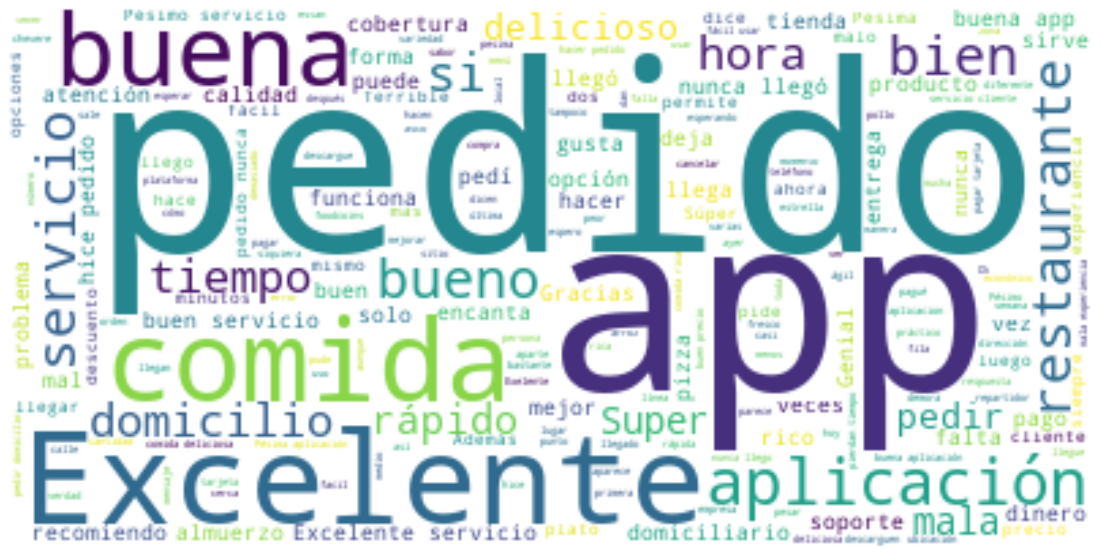

In [ ]:
#Grafico de nube de palabras
full_text = ' '.join(df['content'])
cloud_no_stopword = WordCloud(background_color='white', stopwords=spanish_stopwords).generate(full_text)
plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.rcParams["figure.figsize"] = (30, 10)
plt.show()

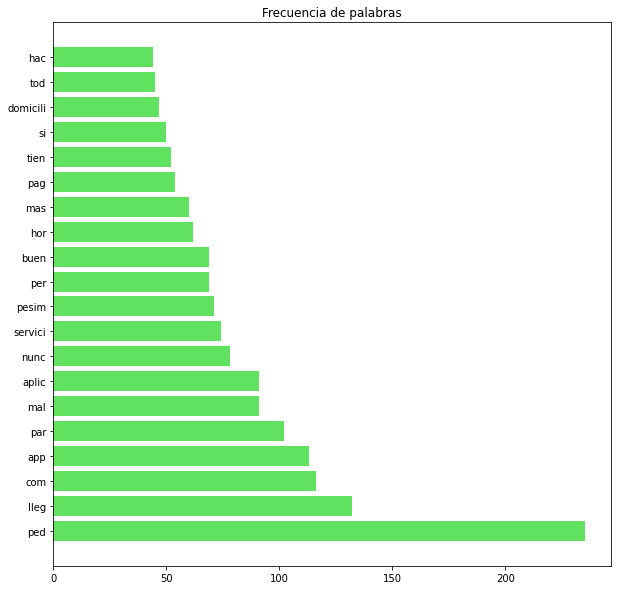

In [ ]:
#ahora analizamos con que frecuencia aparecen las palabras (tokenizadas y con stemmed). En caso de duda consultar help(tokenize)
word_tokens = tokenize(full_text)
tokens = list()
for word in word_tokens:
    if word not in spanish_stopwords:
        tokens.append(word)
token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])
dist.sort_values(by = 'Frequency', ascending=False, inplace=True)
plt.barh(dist.Word, width = dist.Frequency, color ='xkcd:lightish green')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["figure.figsize"] = (10, 10)
plt.title('Frecuencia de palabras')
plt.show()

  No obstante, como pudimos ver en el análisis exploratorio, más del 50% de las personas califica la app con 5 estrellas. Aunque esto es una buena señal, no podemos omitir aquellas personas que no califican perfecto la app. Por lo que escogimos aquellos puntajes debajo de 5 para saber qué opinaba la gente.

  Ahora vemos la otra cara de la moneda. Palabras como "nunca llegó" o "mala" nos dan un indicio que existen dolores en los usuarios que no están siendo curados. Al igual que en el anterior, corrobaramos la información con un top 20 de palabras.

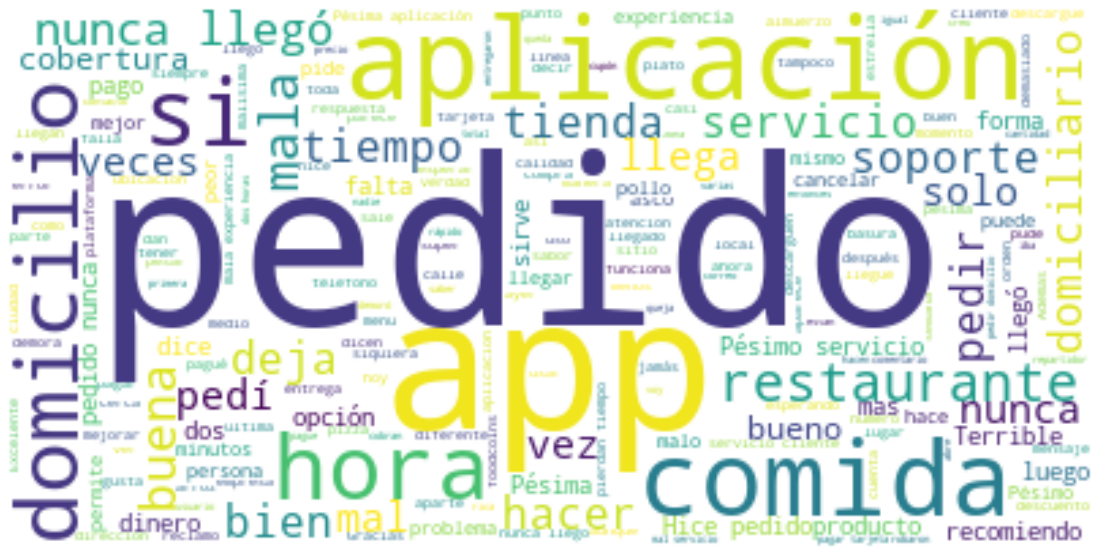

In [ ]:
#ahora estudiemos aquellos reviews que no han sido buenos
df_lower = df[df['score']<5]#Todos los comentarios con calificacion menor a 4
full_text = ' '.join(df_lower['content'])
cloud_no_stopword = WordCloud(background_color='white', stopwords=spanish_stopwords).generate(full_text)
plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.rcParams["figure.figsize"] = (30, 10)
plt.show()

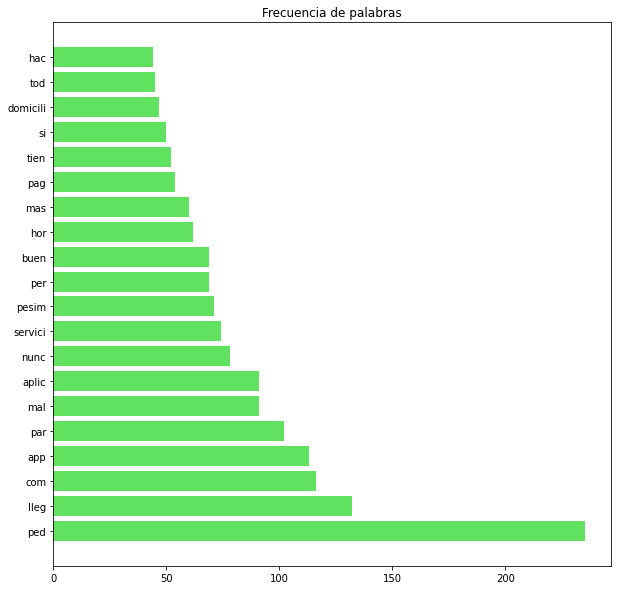

In [ ]:
word_tokens = tokenize(full_text)
tokens = list()
for word in word_tokens:
    if word not in spanish_stopwords:
        tokens.append(word)
token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])
dist.sort_values(by = 'Frequency', ascending=False, inplace=True)
plt.barh(dist.Word, width = dist.Frequency, color ='xkcd:lightish green')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["figure.figsize"] = (10, 10)
plt.title('Frecuencia de palabras')
plt.show()

  A continuación, se tomaron la totalidad de los comentarios y se corrió un sentimiento de análisis usadno sentiment-analysis-spanish. Esta red neuronal convolucional se encarga de asignar un score al sentimiento de la gente. Este Score se promedió y se mostró mes a mes. Esto fue lo que arrojó la gráfica.

  Como se puede apreciar, se graficó un umbral neutro en donde la curva oscila entre pensamientos negativos y positivos. Se puede ver que al inicio de la app, la gente permanecía ecéptica pero a finales del 2019 y durante todo 2020 el sentimiento era positivo. No obstante, desde ese punto en adelante, el score ha venido cayendo. Esto implica investigar a fondo que está sucediendo.

In [ ]:
#Examinemos la evolucion de los sentimientos a lo largo del tiempo
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
df['sentiment_score'] = [sentiment.sentiment(comment) for comment in df.content.values] 

Text(0.5, 1.0, 'sentimientos a lo largo del tiempo')

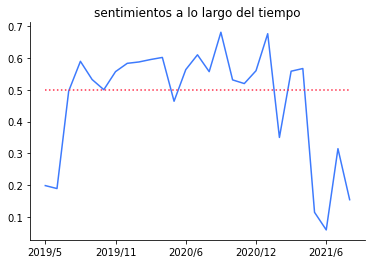

In [ ]:
last_months = df.copy()
#extraemos ano y mes para ignorar los dias
last_months['year'] = pd.DatetimeIndex(last_months['date']).year
last_months['month'] = pd.DatetimeIndex(last_months['date']).month
#agrupamos sacando el promedio
last_months = last_months.groupby(['year', 'month'], as_index=False)['sentiment_score'].mean()
last_months['date'] = last_months['year'].astype(str) + "/"+ last_months['month'].astype(str) 
#visualizamos
ax =  plt.gca()
plt.plot(last_months.date, last_months.sentiment_score, c = 'xkcd:lightish blue')
plt.plot(last_months.date, [0.5 for i in last_months.date], c = 'xkcd:lightish red', ls = 'dotted')
ax.set_xticks(ax.get_xticks()[::6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('sentimientos a lo largo del tiempo')

  Para terminar, se programó un modelo de aprendizaje supervisado para clasificar comentarios buenos y malos. Para ello se probaron 9 modelos de clasificación y se escogió el Naive Bayes Gaussiano por su interpretabilidad, capacidad de generalización y precisión.

  En este modelo, se obtuvo una precisión del 100% sobre el set de entrenamiento y una del 92% en el set de prueba. Adicionalmente, se evaluó el modelo con las métricas ROC y AUC y se obtuvo un área sobre la curva del 92%. En la última celda de este apartado podrás leer la matriz de confusión.

In [ ]:
#Ahora entrenaremos un modelo para analizar los sentimientos
#primero creemos un target
df['target'] = np.where(df['score']>=3,1,0)
#ahora miremos si nuestra data esta balanceada
print(df.target.value_counts()/len(df))

1    0.69064
0    0.30936
Name: target, dtype: float64


In [ ]:
#como tenemos imbalanced classes, deberemos muestrear de otra manera que simplemente aleatoriamente
df_split = vectorizer.fit_transform(df.content)
df_split = pd.DataFrame(df_split.toarray(), columns=vectorizer.get_feature_names())
df_split['target'] = df.target

split = StratifiedShuffleSplit(n_splits =1, test_size = 0.4, random_state = 42)
for i, j in split.split(df_split, df_split.target):
  strat_train_set = df_split.loc[i]
  strat_test_set = df_split.loc[j]

print("training set ->")
print(strat_train_set.target.value_counts()/len(strat_train_set))
print("test set ->")
print(strat_test_set.target.value_counts()/len(strat_test_set))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


training set ->
1    0.691297
0    0.308703
Name: target, dtype: float64
test set ->
1    0.689655
0    0.310345
Name: target, dtype: float64


In [ ]:
#Ahora si definimos variables
x_train, x_test = strat_train_set.iloc[:,:-1],strat_test_set.iloc[:,:-1]
y_train, y_test = strat_train_set.target, strat_test_set.target

In [ ]:
#Metemos los modelos en una lista, entonces podremos probar aquel con mejor metrica
models = list()
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('linear_SVC', SVC()))
models.append(('Dtree', DecisionTreeClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GDC', GradientBoostingClassifier()))

#Ahora iteraremos de modelo en modelo para escoger el mejor
metrics = dict()
for name, model in models:
    kfold = KFold(n_splits = 2)
    cv_result = cross_val_score(model, x_train, y_train, cv = kfold,
                                scoring = "accuracy")
    metrics[name] = cv_result  
dresults = pd.DataFrame(metrics)
dresults

,LR,NB,RF,SVC,linear_SVC,Dtree,XGB,KNN,GDC
0,1.0,0.904918,0.970492,0.944262,0.944262,1.0,1.0,0.957377,1.0
1,1.0,0.881579,0.980263,0.940789,0.940789,1.0,1.0,0.940789,1.0


In [ ]:
#escojemos el modelo Gaussiano de Naive Bayes y lo evaluamos con ROC-AUC
gn = GaussianNB()
gn.fit(x_train, y_train)

print("Accuracy on training set: {}".format(gn.score(x_train, y_train)))
print("Accuracy on test set: {}".format(gn.score(x_test, y_test)))

y_pred = gn.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

print(classification_report(y_test, y_pred))
print('confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('AUC score: ')
print(auc(fpr, tpr))

Accuracy on training set: 1.0
Accuracy on test set: 0.9187192118226601
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       126
           1       0.91      0.98      0.94       280

    accuracy                           0.92       406
   macro avg       0.93      0.88      0.90       406
weighted avg       0.92      0.92      0.92       406

confusion matrix: 
[[ 99  27]
 [  6 274]]
AUC score: 
0.8821428571428571


#**Topic Modeling**#
Como se mencionó anteriormente, es evidente que existen dolores en los usuarios (por ahora minorías) que deben ser curadas para mejorar. Por ello inspeccionamos a fondo por medio de un topic modeling para saber que es lo que está hablando la gente y poder mejorar.

Se pudieron identificar 6 temas relevantes por medio del método LDA (latent Direchlet Allocation):

1.) **Promesa del negocio**: Aquí se encuentran aspectos como satisfacer las necesidades del cliente, cumplir con la promesa de llevarles lo que ordenaron y cómo lo ordenaron.


2.) **App**: Aquí se encuentra la facilidad para usar la aplicación, así como también el soporte que se le brinda al cliente.


3.) **Tiempo de espera**: Todo lo que tiene que ver con el tiempo que se tarda el cliente en hacer su pedido y obtener su comida.


4.) **ST**: Aquí se encuentran otros aspectos.


5.) **Facilidad de pago**: La manera en que los clientes pagan, cuántas opciones tienen y qué tan fácil es según su perfil psicográfico y demográfico.


6.) **Cobertura**: Hasta donde llega la aplicación con un óptimo servicio.

In [ ]:
#topic modeling
df_topic = df[df.score <= 3].loc[:,['reviewId', 'content']]#solo analizaremos lo negativo para saber que mejorar
df_topic.drop_duplicates(inplace = True)
df_topic.dropna(inplace = True)
df_topic = df_topic.reset_index().drop(columns='index')
new_vectorizer = CountVectorizer(
                analyzer = 'word',
                #tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords,
                max_df=0.95, #omitimos palabras frecuencia igual a 95%
                min_df=2, #palabras que ocurren en al menos dos comentarios
                ngram_range = (1,2)#tanto bigramas como unigramas
                )
dt = new_vectorizer.fit_transform(df_topic.content)
dt

In [ ]:
#Extraemos el texto por medio de LDA
LDA = LatentDirichletAllocation(n_components=6,random_state=1)
LDA.fit(dt)
#Extraemos los temas y el top 20 de palabras
fil = [ 'asco', 'mala','peor', 'mal', 'pésima', 'pésimo',
       'terrible', 'buena', 'tan', 'tan mala',
       'bien','si','imposible','mismo','malo',
       ]#se quitan palabras subjetivas
get_names = new_vectorizer.get_feature_names()
for index,topic in enumerate(LDA.components_):
    print(f'topic #{index} : ')
    print([get_names[i] for i in topic.argsort()[-20:]if get_names[i] not in fil])

topic #0 : 
['minutos', 'pago', 'horas', 'domicilio', 'pedí', 'cancelar', 'nunca', 'nunca llegó', 'pésimo servicio', 'deja', 'llegó', 'aplicación', 'servicio', 'comida', 'pedido']
topic #1 : 
['hacer', 'robaron', 'recomiendo', 'llegar', 'pésima aplicación', 'orden', 'hice', 'servicio', 'horas', 'pedidos', 'experiencia', 'dinero', 'app', 'nunca', 'hora', 'aplicación', 'soporte', 'pedido']
topic #2 : 
['nadie', 'comida', 'hora', 'horas', 'tiempo', 'hacer', 'hice', 'hice pedido', 'nunca llegó', 'pedidos', 'servicio', 'llegó', 'nunca', 'aplicación', 'app', 'pedido']
topic #3 : 
['pedir domicilio', 'llegó', 'solo', 'pollo', 'pedí', 'vez', 'comida', 'llega', 'pedir', 'nunca llego', 'horas', 'tiempo', 'app', 'domicilio', 'llego', 'aplicación', 'pedido', 'nunca']
topic #4 : 
['llegó', 'dos', 'momento', 'problemas', 'tarjeta crédito', 'ahora', 'abre', 'cliente', 'experiencia', 'ningún', 'pagar tarjeta', 'crédito', 'tarjeta', 'servicio', 'pedido', 'pagar', 'app']
topic #5 : 
['dinero', 'puede', 

In [ ]:
#por ultimo integraremos los resultados a la base de datos
results = LDA.transform(dt)
df_results = pd.DataFrame(results, columns=[
                                            '0_promesa_negocio',
                                            '1_aplicacion_soporte' ,
                                            '2_tiempo_espera',
                                            '3_ST',
                                            '4_facilidad_de_pago',
                                            '5_cobertura' 
                                            ])
df_final = pd.merge(df_topic, df_results, how = 'inner',
                    left_index = True, right_index=True)
#en caso de querer una base datos con todo entonces
df_whole = pd.merge(df, df_final, on = 'reviewId', how = 'left')
df_whole.fillna('Missing', inplace = True)
df_final

,reviewId,content,0_promesa_negocio,1_aplicacion_soporte,2_tiempo_espera,3_ST,4_facilidad_de_pago,5_cobertura
0,gp:AOqpTOE7pLbVWJkA9nuthQhWEvOh1z7TqXKOmz5Iqan...,"descargue la aplicacion y no me deja ingresar,...",0.966407,0.006719,0.006730,0.006727,0.006718,0.006700
1,gp:AOqpTOFSwX_Iyj91Ypb6_UtOZg5KX8JZ1panGSxKg_6...,No sirve para nada viven con el sistema caído ...,0.010469,0.010424,0.010521,0.947665,0.010420,0.010501
2,gp:AOqpTOFoCxw-nKwCGAI5TXKLc-UA3QLSKvb6RoOlTLZ...,He intentado pedir domicilio varias veces a la...,0.006693,0.006721,0.006705,0.966426,0.006712,0.006744
3,gp:AOqpTOFTrE7lDD47fSogWtxZKNTAUnPfXYoWKU-4v-f...,no sirve para nada que decepcion,0.083765,0.083338,0.083334,0.084111,0.083518,0.581934
4,gp:AOqpTOGvrt1g2fmwhpzWy8rQ_tfAc-d09jF_d9py5vP...,"Como paso el boom ya estan bajando la calidad,...",0.005788,0.005774,0.005768,0.005798,0.971107,0.005765
...,...,...,...,...,...,...,...,...
352,gp:AOqpTOGVCaCDiZmKI4gkm_cPlNoIdaM9Ckw0n-Cc9O3...,Nisiquiera llega el código de verificación. Va...,0.014120,0.013922,0.013940,0.014078,0.929936,0.014004
353,gp:AOqpTOGjttd1hOFd7kQ8nXzg3VMON68ILCjX5fHaMR0...,"Por el momento muy buen servicio, el tiempo de...",0.008003,0.007992,0.413268,0.008004,0.554746,0.007987
354,gp:AOqpTOHmP0wPY1vuGI3Ep0ZDZPAmbs8iXDU2aXQVYjr...,"Exageramente mala, la descargue e hice un pedi...",0.006469,0.006464,0.967738,0.006448,0.006437,0.006444
355,gp:AOqpTOH-nG7L1UqnUBzBv3iNw1RRaFlno1W91HzFdBP...,Muy mala apliccacion no tienes ercicio técnico...,0.961831,0.007668,0.007637,0.007641,0.007620,0.007603


Veámos un ejemplo. En la base de datos, se clasificó un comentario negativo, con un gran puntaje en el tema tiempo de espera. He aquí lo que dice el usuario.

In [ ]:
print(df_whole.loc[1012,'content_x'])

Exageramente mala, la descargue e hice un pedido y luego de dos horas y media esperando, el restaurante canceló el pedido por no tener domiciliario. Las opciones de la app no permite mucha interacción. NO RECOMIENDO


In [ ]:
df_whole

,reviewId,userName,userImage,content_x,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,date,reply,response_time,sentiment_score,content_y,0_promesa_negocio,1_aplicacion_soporte,2_tiempo_espera,3_ST,4_facilidad_de_pago,5_cobertura
0,gp:AOqpTOHrJQ24Tr7VNcew_Q0RsS8911ov5zOBdBvOy5-...,fernando herrera l,https://play-lh.googleusercontent.com/a-/AOh14...,"Muy chevere, facil de usar, y completa la expe...",5,5,1.0.8,2019-05-16 17:33:35,"Hola Fernando, gracias por tu comentario, siem...",2019-06-28 20:48:19,2019-05-16 17:33:35,2019-06-28 20:48:19,43 days 03:14:44,3.380729e-01,Missing,Missing,Missing,Missing,Missing,Missing,Missing
1,gp:AOqpTOHoCxDDfbAGh4pNYXYdOAKT1bY3461Mit-9B8x...,Daniel Calvo,https://play-lh.googleusercontent.com/a/AATXAJ...,"Que bella app, los diseñadores deben ser bello...",5,5,1.0.8,2019-05-16 17:36:56,"Hola Daniel, Gracias por tu comentario, todo l...",2019-06-28 20:47:01,2019-05-16 17:36:56,2019-06-28 20:47:01,43 days 03:10:05,6.043788e-02,Missing,Missing,Missing,Missing,Missing,Missing,Missing
2,gp:AOqpTOEa07P4sHUts68VfR5ueTb-Gpo-NVzwuBUiykU...,David Leon,https://play-lh.googleusercontent.com/a-/AOh14...,buena app para solicitar un almuerzo a la medi...,4,1,1.1.7,2019-06-20 00:37:51,"Hola David, próximamente tendremos esta opción...",2019-06-28 20:43:32,2019-06-20 00:37:51,2019-06-28 20:43:32,8 days 20:05:41,2.733817e-05,Missing,Missing,Missing,Missing,Missing,Missing,Missing
3,gp:AOqpTOE7pLbVWJkA9nuthQhWEvOh1z7TqXKOmz5Iqan...,Paula Baez,https://play-lh.googleusercontent.com/a-/AOh14...,"descargue la aplicacion y no me deja ingresar,...",1,4,1.1.7,2019-06-21 16:11:50,"Hola Paulieta, el día 21 de junio presentamos ...",2019-06-28 20:41:35,2019-06-21 16:11:50,2019-06-28 20:41:35,7 days 04:29:45,8.129939e-10,"descargue la aplicacion y no me deja ingresar,...",0.966407,0.00671854,0.00673037,0.00672672,0.00671824,0.00669956
4,gp:AOqpTOFSwX_Iyj91Ypb6_UtOZg5KX8JZ1panGSxKg_6...,Alejandro Orozco Arias,https://play-lh.googleusercontent.com/a-/AOh14...,No sirve para nada viven con el sistema caído ...,1,2,1.1.7,2019-06-21 19:28:45,"Hola Alejandro, ya estamos trabajando en estos...",2019-06-28 20:39:09,2019-06-21 19:28:45,2019-06-28 20:39:09,7 days 01:10:24,3.693015e-09,No sirve para nada viven con el sistema caído ...,0.0104692,0.0104236,0.0105209,0.947665,0.0104203,0.0105007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,gp:AOqpTOGJZIyFV6Vw06vwkaDYqU7cDdiLyH0wZB3sWBy...,julio andres rueda,https://play-lh.googleusercontent.com/a-/AOh14...,"Muy bueno, excelente servicio del domiciliario...",5,0,2.0.46,2021-08-16 19:04:35,Missing,Missing,2021-08-16 19:04:35,Missing,Missing,9.999869e-01,Missing,Missing,Missing,Missing,Missing,Missing,Missing
1012,gp:AOqpTOHmP0wPY1vuGI3Ep0ZDZPAmbs8iXDU2aXQVYjr...,Juan Jose Rivera Zapata,https://play-lh.googleusercontent.com/a-/AOh14...,"Exageramente mala, la descargue e hice un pedi...",1,0,2.0.46,2021-08-17 00:58:17,Missing,Missing,2021-08-17 00:58:17,Missing,Missing,1.907840e-11,"Exageramente mala, la descargue e hice un pedi...",0.00646866,0.00646379,0.967738,0.00644837,0.0064371,0.00644428
1013,gp:AOqpTOH-nG7L1UqnUBzBv3iNw1RRaFlno1W91HzFdBP...,Harrison marin,https://play-lh.googleusercontent.com/a-/AOh14...,Muy mala apliccacion no tienes ercicio técnico...,1,0,2.0.46,2021-08-17 21:41:25,Missing,Missing,2021-08-17 21:41:25,Missing,Missing,6.547590e-20,Muy mala apliccacion no tienes ercicio técnico...,0.961831,0.00766831,0.00763684,0.00764076,0.00761972,0.00760339
1014,gp:AOqpTOEFO_1vrhnk0-9-gtICGnvOG8gAG-O-GD_iGs3...,м є l ι ѕ ѕ α.,https://play-lh.googleusercontent.com/a-/AOh14...,Terrible jaja. Decidí darle una oportunidad a ...,1,0,2.0.46,2021-08-17 23:05:28,Missing,Missing,2021-08-17 23:05:28,Missing,Missing,1.261040e-23,Terrible jaja. Decidí darle una oportunidad a ...,0.961866,0.00760898,0.00764437,0.00761067,0.00764559,0.00762488


In [ ]:
"""
from google.colab import drive
drive.mount('drive')

df_whole.to_excel('data.xlsx')
!cp data.xlsx "drive/My Drive/"
"""

#**Business insights**

Del anterior repositorio podemos sacar varios insights que nos ayudarán a mejorar la operación de Robin Foods.

- Más de la mitad de la gente califica y habla positivamente del negocio. Aquello podría indicar que RobinFoods ha hecho un gran trabajo con sus usuarios.
- Apesar de lo anterior, un cuarto de los usuarios están altamente insatisfechos. Para mejorar es necesario recurrir a una matriz de pain&gain usando los topics anteriormente expuestos.
- Aunque la idea principal del negocio es reducir el trabajo humano al mínimo, es necesario prestar atención al servicio y la calidad. Varios usuarios manifiestan un pobre servicio de soporte del aplicativo. La forma más fácil, es por medio del tacto humano.
- La gente al no tener replies en sus comentarios, podría llegar a subestimar su importancia para RobinFoods. Aquellos detalles son de suma importancia para la excelencia del servicio.
- Es necesario estimar el costo logístico de la aplicación. Gran parte de la ineficiencia que manifiestan los usuarios se debe a grandes tiempos de espera o que simplemente su pedido no llegó. Es mejor concentrarse en un cluster regional el cual se pueda atender al 100% así este represente una reducción en su oferta.
- Es necesario cuestionar el desarrollo front-end de la apliación. ¿Es fácil de usar? ¿Qué debería ir y qué no? ¿Deberíamos correr un estudio de mercado para evaluar la satisfacción del usuario frente a la interfaz?
- Se evidencia que en los momentos de verdad del usuario frente a la aplicación, parte de las personas insatisfechas no sienten el acompañamiento. El cliente jamás estará agusto con servicio en donde no lo escuchan. Para ello, implementar un chatbot capaz de resolver los incovenientes de manera instantánea podría servir.
- Se manifiesta una molestia con el método de pago. Es necesario repasar el target de la aplicación y revisar cuáles son aquellos medios de pago que frecuentan. Estudios demuestran que en las zonas sur de la ciudad, las personas manejan efectivo más que otro medio de pago.

#Referencias

https://www.xataka.com.co/investigacion/el-86-6-de-los-colombianos-usan-android-y-solo-el-7-9-usa-ios

https://www.semana.com/empresas/articulo/como-ha-crecido-la-cadena-de-restaurantes-muy-en-pandemia/303527/

https://www.linkedin.com/pulse/how-scrape-google-play-reviews-4-simple-steps-using-python-kundi/

https://pybonacci.org/2015/11/24/como-hacer-analisis-de-sentimiento-en-espanol-2/

https://medium.com/analytics-vidhya/play-store-app-reviews-textual-data-topic-modelling-using-lda-f24bdbd2910d

https://towardsdatascience.com/text-mining-and-sentiment-analysis-for-yelp-reviews-of-a-burger-chain-6d3bcfcab17b
